In [1]:
import json
from sparsify import SparseCoder
from safetensors.torch import load_model
from transformers import AutoModel

In [2]:
path = '/network/scratch/b/brownet/sae-checkpoints/finetuning-base-model/unnamed/'
with open(path + "config.json", "r") as f:
    config = json.load(f)

In [3]:
from munch import Munch
config = Munch(config)
config.sae = Munch(config.sae)


In [5]:
saes = []

config.sae.keys()
config.hookpoints
config.layers
for layer in config.hookpoints:

    sae = SparseCoder(
        d_in=576,
        cfg=config.sae,
    )
    load_model(
        sae,
        f"{path}{layer}/sae.safetensors",
    )
    saes.append(sae)


In [14]:
saes

[SparseCoder(
   (encoder): Linear(in_features=576, out_features=18432, bias=True)
 ),
 SparseCoder(
   (encoder): Linear(in_features=576, out_features=18432, bias=True)
 ),
 SparseCoder(
   (encoder): Linear(in_features=576, out_features=18432, bias=True)
 ),
 SparseCoder(
   (encoder): Linear(in_features=576, out_features=18432, bias=True)
 ),
 SparseCoder(
   (encoder): Linear(in_features=576, out_features=18432, bias=True)
 ),
 SparseCoder(
   (encoder): Linear(in_features=576, out_features=18432, bias=True)
 ),
 SparseCoder(
   (encoder): Linear(in_features=576, out_features=18432, bias=True)
 ),
 SparseCoder(
   (encoder): Linear(in_features=576, out_features=18432, bias=True)
 ),
 SparseCoder(
   (encoder): Linear(in_features=576, out_features=18432, bias=True)
 ),
 SparseCoder(
   (encoder): Linear(in_features=576, out_features=18432, bias=True)
 )]

In [15]:
!ls /network/scratch/b/brownet/sae-checkpoints/

finetuning-base-model	 finetuning-step-1680000  finetuning-step-960000  seed3
finetuning-step-1200000  finetuning-step-1920000  seed1			  seed4
finetuning-step-1440000  finetuning-step-240000   seed2			  seed5


In [4]:
checkpoints = [
    'finetuning-step-240000',
    'finetuning-step-960000',
    'finetuning-step-1200000',
    'finetuning-step-1440000',
    'finetuning-step-1680000',
    'finetuning-step-1920000',
    'finetuning-base-model',
]

In [5]:
def load_saes(name):
    path = f"/network/scratch/b/brownet/sae-checkpoints/{name}/unnamed/"
    with open(path + "config.json", "r") as f:
        config = json.load(f)

    config = Munch(config)
    config.sae = Munch(config.sae)

    saes = []

    for layer in config.hookpoints:
        sae = SparseCoder(
            d_in=576,
            cfg=config.sae,
        )
        load_model(
            sae,
            f"{path}{layer}/sae.safetensors",
        )
        saes.append(sae)

    return saes

saes_dict = {}
for checkpoint in checkpoints:
    saes_dict[checkpoint] = load_saes(checkpoint)

In [7]:
SAE_INDEX = 0

In [13]:
n_latents = saes_dict['finetuning-step-240000'][SAE_INDEX].W_dec.shape[0]
n_latents

18432

In [37]:
saes_dict['finetuning-step-240000'][SAE_INDEX].encoder.weight.shape

torch.Size([18432, 576])

In [62]:
import random

latents_index = random.sample(range(n_latents), k=10)

In [81]:
import torch

data = []
for latent in latents_index:
    lengths = []
    for checkpoint in checkpoints:
        feature_vector = saes_dict[checkpoint][SAE_INDEX].W_dec[latent].detach()
        lengths.append(torch.norm(feature_vector))
    data.append(lengths)

for i, values in enumerate(data):
    data[i] = [value / values[-1] for value in values]

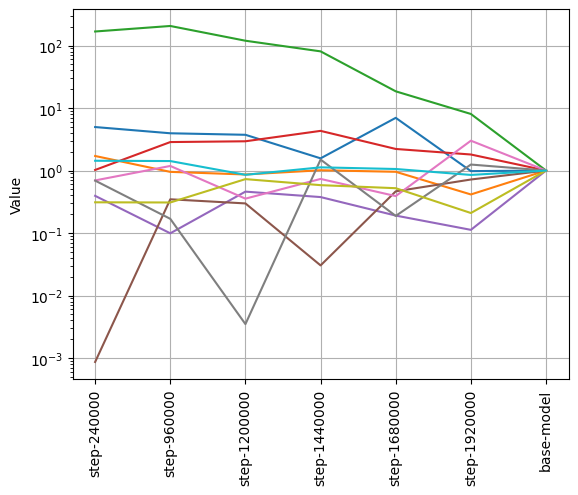

In [94]:
import matplotlib.pyplot as plt

for i, y_values in enumerate(data):
    x_values = list(range(len(y_values)))
    plt.plot([name.lstrip('finetuning-') for name in checkpoints], y_values, label=f"Line {i+1}")

plt.yscale('log')
plt.xticks(rotation=90)
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [85]:
import torch.nn.functional as F

cosine_data = []
for latent in latents_index:
    cosines = []
    for checkpoint in checkpoints:
        ckp_vector = saes_dict[checkpoint][SAE_INDEX].W_dec[latent].detach()
        base_vector = saes_dict['finetuning-base-model'][SAE_INDEX].W_dec[latent].detach()
        
        cosines.append(F.cosine_similarity(ckp_vector, base_vector, dim=0))
    cosine_data.append(cosines)

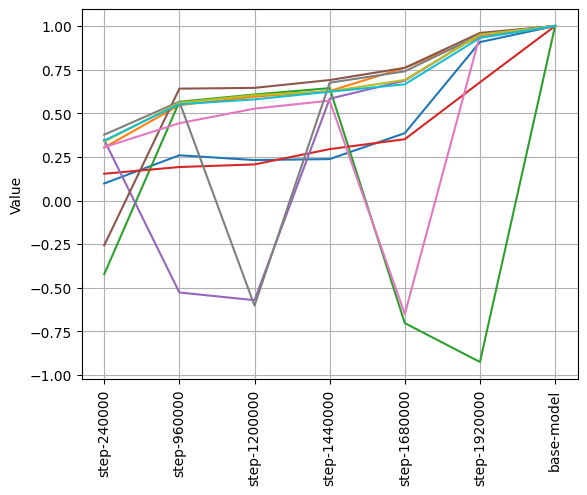

In [97]:

for i, y_values in enumerate(cosine_data):
    x_values = list(range(len(y_values)))
    plt.plot([name.lstrip('finetuning-') for name in checkpoints], y_values, label=f"Line {i+1}")

plt.ylabel("Value")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()